In [1]:
# General imports

from argparse import Namespace
import time
import sys
import pprint
import numpy as np
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import utils
import matplotlib.pyplot as plt
import cv2
import random
import glob
from tqdm import tqdm
import PIL
import PIL.Image
%matplotlib inline

# Importing hyperstyle related

hyperstyle_root = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), 'hyperstyle'))
sys.path.insert(0, hyperstyle_root)

from hyperstyle.utils.model_utils import load_model
from hyperstyle.notebooks.notebook_utils import run_alignment
from hyperstyle.utils.inference_utils import run_inversion

In [2]:
# Define the pSp encoder - StyleGANv2 decoder and load pretrained weights

device = 'cuda'

HYPERSTYLE_ARGS = {
    "hyperstyle_model_path": "./pretrained_models/hyperstyle_ffhq.pt",
    "hyperstyle_w_encoder_path": "./pretrained_models/faces_w_encoder.pt",
    "transform": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
}

# hyper_net, hyper_opts = load_model(HYPERSTYLE_ARGS['hyperstyle_model_path'], update_opts={'w_encoder_checkpoint_path': HYPERSTYLE_ARGS['hyperstyle_w_encoder_path'], 'resize_outputs': False})
hyper_net, hyper_opts = load_model(HYPERSTYLE_ARGS['hyperstyle_model_path'], update_opts={'resize_outputs': False})
hyper_net.eval()
hyper_net.cuda();

c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Stamina\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading HyperStyle from checkpoint: ./pretrained_models/hyperstyle_ffhq.pt
Loading pretrained W encoder...
Using WEncoder
Loading WEncoder from checkpoint: pretrained_models/faces_w_encoder.pt


In [3]:
# Define the function to normalize images and convert to numpy

# This normalization block is taken from the original torch repository:
# https://github.com/pytorch/vision/blob/89d2b38cbc3254ed7ed7b43393e4635979ac12eb/torchvision/utils.py

def norm_ip(img, low, high):
    img.clamp_(min=low, max=high)
    img.sub_(low).div_(max(high - low, 1e-5))

def norm_range(t, value_range):
    if value_range is not None:
        norm_ip(t, value_range[0], value_range[1])
    else:
        norm_ip(t, float(t.min()), float(t.max()))

def normalize_image_and_convert_to_numpy(image):
    norm_range(image, (-1, 1))
    return image.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()

pool_logit = torch.nn.AdaptiveAvgPool2d((256, 256))

In [16]:
# Define a function that generates a random image

def generate_random_image(downscale=False):
    z = torch.randn(1, 512, device=device) # args.sample, args.latent
    gen_img, latent = hyper_net.decoder(
        [z], truncation=1, truncation_latent=None, return_latents=True # args.truncation
    )
    if downscale:
        gen_img = pool_logit(gen_img)
    return Image.fromarray(normalize_image_and_convert_to_numpy(gen_img[0])), latent # returns tensor

# Define a function that generates an image for the given code

def generate_image_given_code(code, weights_deltas=None, downscale=False):
    with torch.no_grad():
        gen_img, latent = hyper_net.decoder(
            [code], truncation=1, truncation_latent=None, return_latents=True, input_is_latent=True, randomize_noise=False, weights_deltas=weights_deltas # args.truncation
        )
        if downscale:
            gen_img = pool_logit(gen_img)
        return Image.fromarray(normalize_image_and_convert_to_numpy(gen_img[0])), latent, weights_deltas # returns tensor

# Define a function that encodes a given image and returns the code alongside its decoding (its 'fake' recreation)

def encode_given_image_return_code_and_recreation(image, downscale=False):
    with torch.no_grad():
        img_transforms = HYPERSTYLE_ARGS['transform']
        transformed_image = img_transforms(image)
        image, latent, weights_deltas, _ = run_inversion(transformed_image.unsqueeze(0).to(device), hyper_net, hyper_opts, return_intermediate_results=False)
        if downscale:
            gen_img = pool_logit(gen_img)
        return image, latent, weights_deltas

# Define a function that generates an image or encodes a given image and returns image-code pair

def generate_an_image_code_pair(image=None, downscale=False):
    if image is None:
        return generate_random_image(downscale)
    else:
        return encode_given_image_return_code_and_recreation(image, downscale)
    
# Define a function to load an image from its path, optionally aligns it and returns loadedimage-generatedimage-code

def load_image_and_encode(path, predictor=None):
    if predictor is not None:
        image = run_alignment(path, predictor)
    else:
        image = PIL.Image.open(path)
    gen_image, gen_code, gen_weights_deltas = encode_given_image_return_code_and_recreation(image)
    gen_image = Image.fromarray(normalize_image_and_convert_to_numpy(gen_image[0]))
    return image, gen_image, gen_code, gen_weights_deltas

In [190]:
# Define a function to neutralize latent code

def neutralize_latent_code(code, neutral_dir, neutral_strength=20):
    code, neutral_dir = code.detach().cpu().flatten(), neutral_dir.detach().cpu().flatten()
    distance = np.dot(neutral_dir, code) / np.linalg.norm(neutral_dir)
    direction = neutral_dir / np.linalg.norm(neutral_dir)
    neutral_code = code - distance * direction
    neutral_code = neutral_code + neutral_strength * direction
    return neutral_code.reshape(18, 512).unsqueeze(0).cuda()

# Define a function to transfer emotion from code A to B

def transfer_emotion_on_code(code_A, code_B, neutral_dir, neutral_strength):
    code_A_neu = neutralize_latent_code(code_A, neutral_dir, neutral_strength)
    code_B_neu = neutralize_latent_code(code_B, neutral_dir, neutral_strength)

    return (code_A - code_A_neu) + code_B_neu

# Define a function to transfer emotion from image A to B

def transfer_emotion_on_image(image_A, image_B, neutral_dir, neutral_strength):
    _, code_A, wd_A = encode_given_image_return_code_and_recreation(image_A)
    _, code_B, wd_B = encode_given_image_return_code_and_recreation(image_B)
    
    image_A_neu, code_A_neu, wd_A_neu = generate_image_given_code(neutralize_latent_code(code_A, neutral_dir, neutral_strength), wd_A)
    image_B_neu, code_B_neu, wd_B_neu = generate_image_given_code(neutralize_latent_code(code_B, neutral_dir, neutral_strength), wd_B)
    
    image_A_neu_inv, code_A_neu_inv, wd_A_neu_inv = encode_given_image_return_code_and_recreation(image_A_neu) 
    image_B_neu_inv, code_B_neu_inv, wd_B_neu_inv = encode_given_image_return_code_and_recreation(image_B_neu)

    transfer_code = (code_A - code_A_neu_inv) + code_B_neu_inv

    return generate_image_given_code(transfer_code, wd_B_neu)[0]

In [6]:
# Load up directions

anger_dir = torch.from_numpy(np.load('main_directions/0.npy').astype(np.float32)).to(device)
contempt_dir = torch.from_numpy(np.load('main_directions/1.npy').astype(np.float32)).to(device)
disgust_dir = torch.from_numpy(np.load('main_directions/2.npy').astype(np.float32)).to(device)
fear_dir = torch.from_numpy(np.load('main_directions/3.npy').astype(np.float32)).to(device)
happiness_dir = torch.from_numpy(np.load('main_directions/4.npy').astype(np.float32)).to(device)
neutral_dir = torch.from_numpy(np.load('main_directions/5.npy').astype(np.float32)).to(device)
sadness_dir = torch.from_numpy(np.load('main_directions/6.npy').astype(np.float32)).to(device)
surprise_dir = torch.from_numpy(np.load('main_directions/7.npy').astype(np.float32)).to(device)

In [ ]:
# Execute 200 transfer and save results for observing

with open('experiments/psp_samples.txt', 'r') as file:
    lines = [line[:-1].split(' ') for line in file.readlines()]

from tqdm import tqdm
for i in tqdm(range(len(lines))):
    try:
        if 'Error' in lines[i]:
            continue
        image_src_path, image_dst_path = lines[i][0], lines[i][1]

        image_src, gen_image_src, gen_code_src, gen_weights_deltas = load_image_and_encode(image_src_path, 'pretrained_models/shape_predictor_68_face_landmarks.dat')
        image_dst, gen_image_dst, gen_code_dst, gen_weights_deltas = load_image_and_encode(image_dst_path, 'pretrained_models/shape_predictor_68_face_landmarks.dat')

        transfer_image = transfer_emotion_on_image(image_dst, image_src, neutral_dir, 20)

        fig, axs = plt.subplots(2, 5, figsize=(10, 5))

        axs[0][0].imshow(image_src)
        axs[0][0].set_title('Source_Org')

        axs[0][1].imshow(gen_image_src)
        axs[0][1].set_title('Source')

        axs[0][2].imshow(image_dst)
        axs[0][2].set_title('Destination_Org')

        axs[0][3].imshow(gen_image_dst)
        axs[0][3].set_title('Destination')

        axs[0][4].imshow(transfer_image)
        axs[0][4].set_title('Transfer')

        transfer_image = transfer_emotion_on_image(image_src, image_dst, neutral_dir, 20)

        axs[1][0].imshow(image_dst)
        axs[1][0].set_title('Source_Org')

        axs[1][1].imshow(gen_image_dst)
        axs[1][1].set_title('Source')

        axs[1][2].imshow(image_src)
        axs[1][2].set_title('Destination_Org')

        axs[1][3].imshow(gen_image_src)
        axs[1][3].set_title('Destination')

        axs[1][4].imshow(transfer_image)
        axs[1][4].set_title('Transfer')

        for ax1 in axs:
            for ax2 in ax1:
                ax2.axis('off')

        plt.tight_layout()

        plt.savefig(f'experiments/hyperstyle/{i}.png')

        plt.close()

    except Exception as e:
        pass

In [181]:
image_src_path = 'test.jpg'
image_dst_path = 'test2.jpg'
image_src_path, image_dst_path = random.sample(glob.glob('datasets/celeba_hq/*/*.jpg'), 2)

image_src, gen_image_src, gen_code_src, gen_weights_deltas = load_image_and_encode(image_src_path, 'pretrained_models/shape_predictor_68_face_landmarks.dat')
image_dst, gen_image_dst, gen_code_dst, gen_weights_deltas = load_image_and_encode(image_dst_path, 'pretrained_models/shape_predictor_68_face_landmarks.dat')

In [188]:
# transfer_image = generate_image_given_code(neutralize_latent_code(gen_code2, neutral_dir))[0]
# transfer_image = transfer_emotion_on_image(image_src, image_dst, neutral_dir, 20)
transfer_image = transfer_emotion_on_image(image_dst, image_src, neutral_dir, 20)

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 5, figsize=(10, 5))

axs[0].imshow(image_src)
axs[0].set_title('Source_Org')

axs[1].imshow(gen_image_src)
axs[1].set_title('Source')

axs[2].imshow(image_dst)
axs[2].set_title('Destination_Org')

axs[3].imshow(gen_image_dst)
axs[3].set_title('Destination')

axs[4].imshow(transfer_image)
axs[4].set_title('Transfer')

for ax in axs:
    ax.axis('off')

plt.tight_layout()

plt.show()

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 5, figsize=(10, 5))

axs[0].imshow(image_src)
axs[0].set_title('Source_Org')

axs[1].imshow(gen_image_src)
axs[1].set_title('Source')

axs[2].imshow(image_dst)
axs[2].set_title('Destination_Org')

axs[3].imshow(gen_image_dst)
axs[3].set_title('Destination')

axs[4].imshow(transfer_image)
axs[4].set_title('Transfer')

for ax in axs:
    ax.axis('off')

plt.tight_layout()

plt.show()

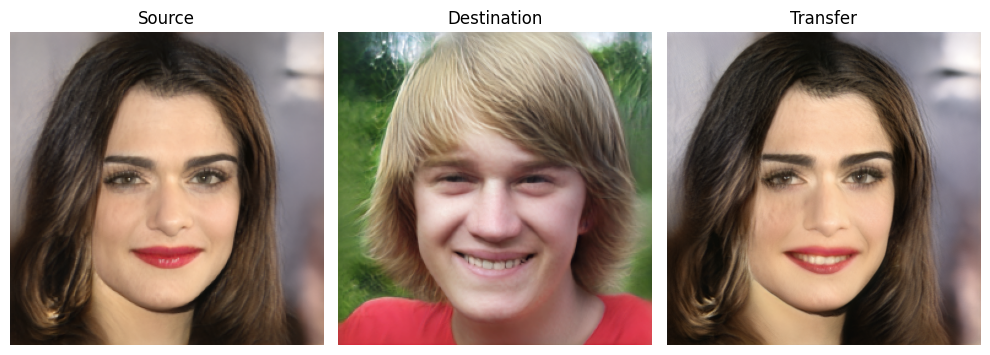

In [98]:
image_src_path = random.sample(glob.glob('datasets/celeba_hq/*/*.jpg'), 1)[0]

image_src, gen_image_src, gen_code_src, gen_weights_deltas = load_image_and_encode(image_src_path, 'pretrained_models/shape_predictor_68_face_landmarks.dat')

image_src_neu_10 = generate_image_given_code(neutralize_latent_code(gen_code_src, neutral_dir, 10), gen_weights_deltas)[0]
image_src_neu_20 = generate_image_given_code(neutralize_latent_code(gen_code_src, neutral_dir, 20), gen_weights_deltas)[0]

%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(gen_image_src)
axs[0].set_title('Org')

axs[1].imshow(image_src_neu_10)
axs[1].set_title('Neu 10')

axs[2].imshow(image_src_neu_20)
axs[2].set_title('Neu 20')

for ax in axs:
    ax.axis('off')

plt.tight_layout()

plt.show()